In [1]:
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def get_latest_output_dir(reward, strategy, policy_cls, index=-1):
    output_dir = sorted(glob.glob(f"../records/{reward}/{strategy}/{policy_cls}/*"))[index]
    return output_dir


def plot_metrics(reward, strategy, policy_cls, scale=1, ann_scaler=252, norm_steps_per_episode=False, index=-1):
    
    output_dir = get_latest_output_dir(reward, strategy, policy_cls, index)
    
    df_base = pd.read_csv(f"{output_dir}/baseline/result.csv")
    df_train = pd.read_csv(f"{output_dir}/metrics/train_result.csv", index_col=0)
    df_valid = pd.read_csv(f"{output_dir}/metrics/validation_result.csv", index_col=0)
    df_base = df_base.loc[df_base.index.repeat(len(df_train))].reset_index(drop=True)

    df_train["reward"] = df_train["reward"] / scale * ann_scaler
    
    if norm_steps_per_episode:
        df_train["reward"] = df_train["reward"] / df_train["steps_per_episode"]
    
    df = pd.DataFrame({
        "baseline": df_base["reward"],
        "train": df_train["reward"],
        "valid": df_valid["val/reward"]
    })
    
    print(f"Loaded metrics from: {output_dir}")
    best = df.fillna(-1).sort_values("valid", ascending=True).iloc[-1].to_dict()
    print(best)
    print(df)
    
    df.plot(figsize=(10, 6))
    plt.legend([f"baseline ({best['baseline']:.5f})", f"train ({best['train']:.5f})", f"valid ({best['valid']:.5f})"])
    plt.title(f"{strategy} ({policy_cls})")
    plt.xlabel("Episode")
    plt.ylabel(reward)

Loaded metrics from: ../records/EpisodeInformationRatioReward/TopkDropoutDynamicStrategy/MetaPPO/2023_03_18_17_34
{'baseline': 1.6110648697763554, 'train': 2.5019091289968585, 'valid': 0.441960251389258}
   baseline     train    valid
0  1.611065  2.501909  0.44196


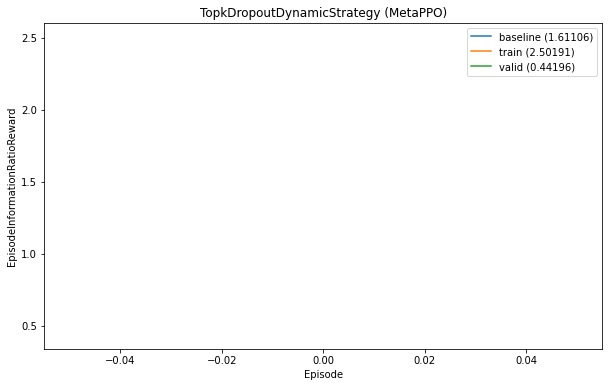

In [3]:
plot_metrics(
    reward="EpisodeInformationRatioReward",
    strategy="TopkDropoutDynamicStrategy",
    policy_cls="MetaPPO",
    scale=1,
    ann_scaler=1,
    norm_steps_per_episode=False
)